**Задача: определить повлияло ли изменение стоимости преимум-подписки (в некоторых странах) на выручку**
1. Метрики: 
- **выручка c пользователя (целевавая)**
- кол-во внутренней валюты у пользователей (прокси)
- **кол-во пользователей с преимум (прокси)**
- кол-во новых пользователей с премиум (прокси)
- среднее время между регистрацией и покупкой (прокси)
- **кол-во покупок на 1 пользователя в рассматриваемый период (прокси)**
- средний чек (прокси)
2. Группы пользователей:
- пол (2 группы)
- возраст (более 2)
- **страна (более 2)**
- активность (-)
- привлекательность (-)
- наличие\отсутвтсие премиум (2 группы)
- наличие\отсутвтсие внутренней валюты (2 группы)
3. Выбор статистического теста:
- метрика - непрервная, необходимо выявить различие средних значений
- распределение - ненормально
- дисперсии равны

In [141]:
import pandas as pd, numpy as np
import seaborn as sns, pingouin as pg
import matplotlib.pyplot as plt, matplotlib.ticker as ticker
from IPython.display import display, HTML, clear_output
PATH = './data/'

In [5]:
users_testDF = pd.read_csv(PATH + 'Проект_3_users_test.csv', sep = ';', on_bad_lines='warn')
users_ctrlDF_1 = pd.read_csv(PATH + 'Проект_3_users_control_1.csv', sep = ';', on_bad_lines='warn')
users_ctrlDF_2 = pd.read_csv(PATH + 'Проект_3_users_control_2.csv', sep = ';', on_bad_lines='warn')

trans_testDF = pd.read_csv(PATH + 'Проект_3_transactions_test.csv', sep = ';', on_bad_lines='warn')
trans_ctrlDF_1 = pd.read_csv(PATH + 'Проект_3_transactions_control_1.csv', sep = ';', on_bad_lines='warn')
trans_ctrlDF_2 = pd.read_csv(PATH + 'Проект_3_transactions_control_2.csv', sep = ';', on_bad_lines='warn')

In [6]:
display(users_testDF.head())
display(trans_testDF.head())

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [7]:
# рассмотрим данные пользователей, попробуем выделить характерные группы пользователей для многофактоного анализа
bins = [15, 18, 25, 30, 35, 45, 50, 60, 65, 99]
(users_testDF
.assign(activity = lambda x: (x['visit_days']).str.split(',')
                              .apply(lambda i: len(i) if type(i) == list else (np.nan if np.isnan(i) else 1)))
.assign(age_bins = lambda x: pd.cut(x['age'], bins))
.groupby(['gender','age_bins'], observed = False)
.apply(lambda group: pd.Series({
        'count_users' : group['uid'].count(),                         #кол-во users
        'count_premium' : group['was_premium'].count(),               #кол-во преимум аккаунтов (когда либо)
        'have_coins': group['coins'].count(),                         #кол-во аккаунтов с coins > 0
                                                                      #средняя выручка на пользователя (учитываем только донативших пользователей)
        'mean_tot_revenue_notZero':  group[group['total_revenue'] > 0]['total_revenue'].mean(),  
        'mean_activity' : group['activity'].mean(),                   #средняя активность users
        'mean_views': group['views_count'].mean(),                    #среднее кол-во просмотров
        'mean_MIN_partner_age' : group['age_filter_start'].mean(),    #минимальный возраст партнера (среднее)
        'mean_MAX_partner_age' : group['age_filter_end'].mean(),      #макимальный возраст партнера (среднее)
}), include_groups=False)
)

count_users  count_premium  have_coins  \
gender age_bins                                           
0      (15, 18]         15.0            1.0         1.0   
       (18, 25]         53.0            1.0         0.0   
       (25, 30]         55.0            2.0         1.0   
       (30, 35]         42.0            3.0         0.0   
       (35, 45]         32.0            2.0         0.0   
       (45, 50]          NaN            NaN         NaN   
       (50, 60]          4.0            0.0         0.0   
       (60, 65]          1.0            0.0         0.0   
       (65, 99]          NaN            NaN         NaN   
1      (15, 18]        179.0           27.0         1.0   
       (18, 25]       1058.0          113.0        11.0   
       (25, 30]        915.0           75.0         9.0   
       (30, 35]        646.0           73.0        12.0   
       (35, 45]        852.0           78.0         9.0   
       (45, 50]        231.0           16.0         2.0   
       (50, 60]        199.0           14.0         2.0   
       (60, 65]         10.0            2.0         0.0   
       (65, 99]         16.0            1.0         1.0   

                 mean_tot_revenue_notZero  mean_activity   mean_views  \
gender age_bins                                                         
0      (15, 18]                       NaN       8.333333  1188.733333   
       (18, 25]              12727.000000       5.628571   473.415094   
       (25, 30]                       NaN       6.085714   513.800000   
       (30, 35]              14352.000000       7.321429   684.571429   
       (35, 45]                       NaN       6.772727   436.031250   
       (45, 50]                       NaN            NaN          NaN   
       (50, 60]                       NaN      14.000000  1668.750000   
       (60, 65]                       NaN            NaN    61.000000   
       (65, 99]                       NaN            NaN          NaN   
1      (15, 18]              20631.000000       7.245283    18.508380   
       (18, 25]              15597.705882       6.205594    14.747637   
       (25, 30]              16949.833333       6.663987    18.773770   
       (30, 35]              14706.939394       6.629139    21.736842   
       (35, 45]              16853.777778       6.824104    30.782864   
       (45, 50]              11710.833333       6.590909    38.991342   
       (50, 60]              10723.375000       7.071942    48.442211   
       (60, 65]                       NaN       8.375000    65.700000   
       (65, 99]              47242.000000       9.230769    49.750000   

                 mean_MIN_partner_age  mean_MAX_partner_age  
gender age_bins                                              
0      (15, 18]             17.466667             35.400000  
       (18, 25]             19.943396             30.754717  
       (25, 30]             26.872727             44.200000  
       (30, 35]             31.523810             54.500000  
       (35, 45]             36.937500             47.468750  
       (45, 50]                   NaN                   NaN  
       (50, 60]             41.750000             56.000000  
       (60, 65]             62.000000             68.000000  
       (65, 99]                   NaN                   NaN  
1      (15, 18]             16.748603             26.569832  
       (18, 25]             19.338374             29.381853  
       (25, 30]             23.650273             35.006557  
       (30, 35]             27.461300             39.399381  
       (35, 45]             33.151408             44.868545  
       (45, 50]             39.051948             50.709957  
       (50, 60]             41.969849             56.341709  
       (60, 65]             40.800000             62.700000  
       (65, 99]             39.625000             61.125000

**A/A test, метрика - total_revenue**

1. Исходные распредения: 



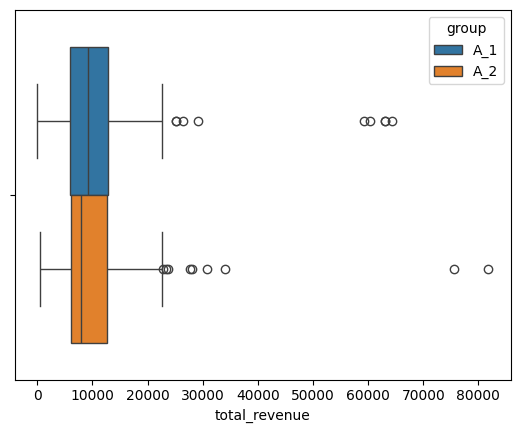

2. Возьмем логарифм, возьмем ненулевые значения total_revenue

3. Проверка на нормальность: 



,W,pval,normal
total_revenue,0.870498,9.241721e-12,False


,W,pval,normal
total_revenue,0.964343,0.000108,False


4. Проверка на равенство дисперсий: 



,W,pval,equal_var
levene,0.287066,0.592423,True


5. Распределения после фильтрации и логарифмирования: 



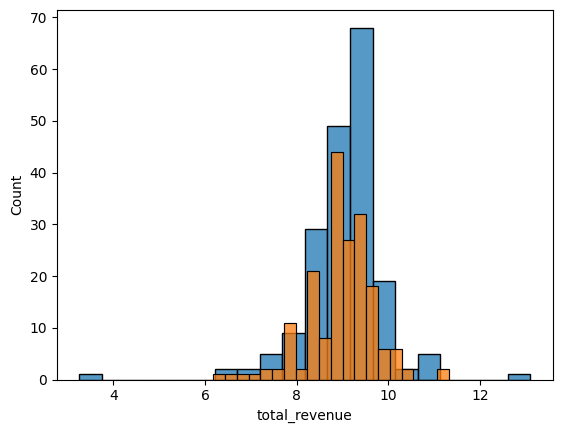

In [8]:
print('1. Исходные распредения: \n')
two_groups = pd.concat([users_ctrlDF_1.assign(group = 'A_1'), 
                        users_ctrlDF_2.assign(group = 'A_2')], axis = 0)
sns.boxplot(data = two_groups.query('(total_revenue > 0) & (total_revenue < 100_000)'), x = 'total_revenue', hue = 'group')
plt.show()

print('2. Возьмем логарифм, возьмем ненулевые значения total_revenue\n')
distr_1 = np.log(users_ctrlDF_1.query('total_revenue > 0')['total_revenue'])
distr_2 = np.log(users_ctrlDF_2.query('total_revenue > 0')['total_revenue'])

print('3. Проверка на нормальность: \n')
display(pg.normality(distr_1))
display(pg.normality(distr_2))

print('4. Проверка на равенство дисперсий: \n')
two_groups = pd.concat([distr_1.to_frame().assign(group = 'A_1'), 
                        distr_2.to_frame().assign(group = 'A_2')], axis = 0)
display(pg.homoscedasticity(data=two_groups, dv="total_revenue", group="group"))

print('5. Распределения после фильтрации и логарифмирования: \n')
plt.clf()
sns.histplot(distr_1, bins = 20)
sns.histplot(distr_2, bins = 20)
plt.show()

In [9]:
result = (pg.ttest(distr_1,distr_2, alternative='two-sided'))
alfa = 0.05
display(result)
if result['p-val'].iloc[0] > alfa:
    print('Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот')
else:
    print('Отклоняем H0. В сравниваемых группах существует различие в распределении частот')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.645636,366.874773,two-sided,0.518918,"[-0.11, 0.22]",0.066166,0.139,0.098448


Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот


**A/B test**

1. Исходные распредения: 



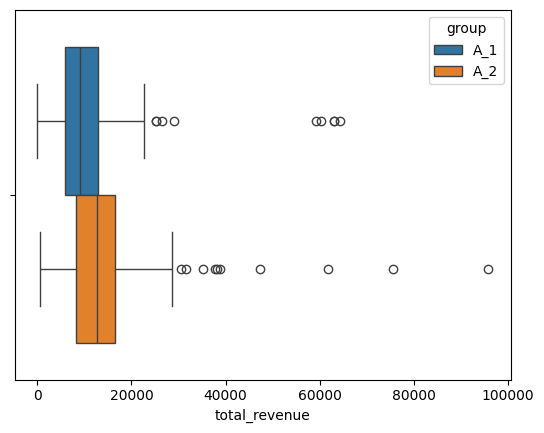

2. Возьмем логарифм, возьмем ненулевые значения total_revenue

3. Проверка на нормальность: 



,W,pval,normal
total_revenue,0.870498,9.241721e-12,False


,W,pval,normal
total_revenue,0.923067,4.563834e-07,False


4. Проверка на равенство дисперсий: 



,W,pval,equal_var
levene,0.013856,0.906368,True


5. Распределения после фильтрации и логарифмирования: 



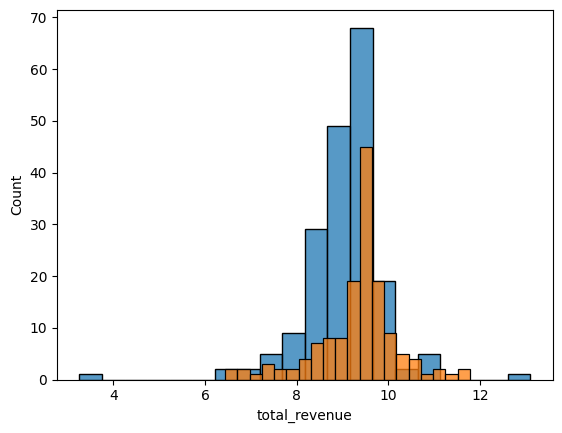

In [10]:
print('1. Исходные распредения: \n')
two_groups = pd.concat([users_ctrlDF_1.assign(group = 'A_1'), 
                        users_testDF.assign(group = 'A_2')], axis = 0)
sns.boxplot(data = two_groups.query('(total_revenue > 0) & (total_revenue < 100_000)'), x = 'total_revenue', hue = 'group')
plt.show()

print('2. Возьмем логарифм, возьмем ненулевые значения total_revenue\n')
distr_1 = np.log(users_ctrlDF_1.query('total_revenue > 0')['total_revenue'])
distr_2 = np.log(users_testDF.query('total_revenue > 0')['total_revenue'])

print('3. Проверка на нормальность: \n')
display(pg.normality(distr_1))
display(pg.normality(distr_2))

print('4. Проверка на равенство дисперсий: \n')
two_groups = pd.concat([distr_1.to_frame().assign(group = 'A_1'), 
                        distr_2.to_frame().assign(group = 'A_2')], axis = 0)
display(pg.homoscedasticity(data=two_groups, dv="total_revenue", group="group"))

print('5. Распределения после фильтрации и логарифмирования: \n')
plt.clf()
sns.histplot(distr_1, bins = 20)
sns.histplot(distr_2, bins = 20)
plt.show()

In [11]:
result = (pg.mwu(distr_2,distr_1, alternative='two-sided'))
alfa = 0.05
display(result)
if result['p-val'].iloc[0] > alfa:
    print(f'Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот')
else:
    effect = (np.exp(distr_2).mean() - np.exp(distr_1).mean() ) / np.exp(distr_1).mean() * 100 
    print(f'Отклоняем H0. В сравниваемых группах существует различие в распределении частот. Разница составляет ~ {effect.round()} %')

,U-val,alternative,p-val,RBC,CLES
MWU,17281.5,two-sided,0.000242,-0.232984,0.616492


Отклоняем H0. В сравниваемых группах существует различие в распределении частот. Разница составляет ~ 17.0 %


**A/A test. Метрика - кол-во пользователей с пемиум аккаунтом**

In [69]:
# was_premium - был ли когда либо премиум у аккаунта
# was_premium = 1 всегда если is_premium = 1
# рассчитаем долю is_premium из числа was_premium и воспользуемся z - тестом для разности двух долей
from statsmodels.stats.proportion import proportions_ztest
is_premium = [
    users_ctrlDF_1.query("is_premium ==1").shape[0], 
    users_ctrlDF_2.query("is_premium ==1").shape[0], ]
was_premium = [
    users_ctrlDF_1.query("was_premium ==1").shape[0], 
    users_ctrlDF_2.query("was_premium ==1").shape[0], ]

print(f'Кол-во пользователей с премиум - {is_premium}, без премиум - {was_premium}')
z_stat, pval = proportions_ztest(is_premium, was_premium)
if pval > alfa:
    print(f'p-val = {pval.round(3)}. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот')
else:
    print(f'p-val = {pval.round(3)}. Отклоняем H0. В сравниваемых группах существует различие в распределении частот')

Кол-во пользователей с премиум - [192, 191], без премиум - [436, 411]
p-val = 0.477. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот


**A/B test. Метрика - кол-во пользователей с пемиум аккаунтом**

In [70]:
is_premium = [
    users_ctrlDF_1.query("is_premium ==1").shape[0], 
    users_testDF.query("is_premium ==1").shape[0], ]
was_premium = [
    users_ctrlDF_1.query("was_premium ==1").shape[0], 
    users_testDF.query("was_premium ==1").shape[0], ]

print(f'Кол-во пользователей с премиум - {is_premium}, без премиум - {was_premium}')
z_stat, pval = proportions_ztest(is_premium, was_premium)
if pval > alfa:
    print(f'p-val = {pval.round(3)}. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот')
else:
    print(f'p-val = {pval.round(3)}. Отклоняем H0. В сравниваемых группах существует различие в распределении частот')

Кол-во пользователей с премиум - [192, 157], без премиум - [436, 408]
p-val = 0.101. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот


**A/A - A/B test. Метрика - кол-во покупок**

In [71]:
# premium_purchase - кол-во покупок премиум аккаунтов для каждого пользователя
# all_purchase - кол-во всех покупок для каждого пользователя
users = {'B': users_testDF, 'A_1' : users_ctrlDF_1, 'A_2': users_ctrlDF_2}
trans = {'B': trans_testDF, 'A_1': trans_ctrlDF_1, 'A_2' : trans_ctrlDF_2}
data = []

for idx in users.keys():
    curr_users = (users[idx]
        .assign(group = idx)
    )
    curr_trans = (trans[idx]
                    .groupby('uid')
                    .apply(lambda group: pd.Series({
                        'tot_revenue_premium': group[group['product_type'] == 'premium_no_trial']['revenue'].sum(), 
                        'tot_revenue_all': group['revenue'].sum(), 
                        'premium_purchase': group[group['product_type'] == 'premium_no_trial']['product_type'].count(),
                        'all_purchase' : group['product_type'].count(),
                    }), include_groups=False)
                    .assign(revenue_premium_share = lambda x: x['tot_revenue_premium'] / x['tot_revenue_all'])
                    .assign(group = idx)
                    ).reset_index()
    data.append(curr_users.merge(curr_trans, on = ['uid', 'group'], how = 'left'))
data = pd.concat(data, axis = 0).reset_index()

**Метрика - кол-во покупок премиум аккаунтов**

In [72]:
from scipy.stats import chi2_contingency
data.fillna({'premium_purchase': 0}, inplace = True)
observed = data.pivot_table(index = 'group', columns = 'premium_purchase', values = 'uid', aggfunc = 'count').fillna(0).astype(int)
display(observed)

print('A/A Тест:')
chi2, pval, dof, expected = chi2_contingency(observed.loc[['A_1', 'A_2']].to_numpy())
if pval > alfa:
    print(f'p-val = {pval.round(3)}. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот')
else:
    print(f'p-val = {pval.round(3)}. Отклоняем H0. В сравниваемых группах существует различие в распределении частот')

print('A/B Тест:')
chi2, pval, dof, expected = chi2_contingency(observed.loc[['A_1', 'B']].to_numpy())
if pval > alfa:
    print(f'p-val = {pval.round(3)}. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот')
else:
    print(f'p-val = {pval.round(3)}. Отклоняем H0. В сравниваемых группах существует различие в распределении частот')

premium_purchase,0.0,1.0,2.0,3.0
group,,,,
A_1,4241,92,7,0
A_2,4162,98,3,1
B,4241,61,3,3


A/A Тест:
p-val = 0.414. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот
A/B Тест:
p-val = 0.013. Отклоняем H0. В сравниваемых группах существует различие в распределении частот


**Метрика - кол-во всех покупок в приложении**

In [73]:
data.fillna({'all_purchase': 0}, inplace = True)
observed = data.pivot_table(index = 'group', columns = 'all_purchase', values = 'uid', aggfunc = 'count').fillna(0).astype(int)
display(observed)

print('A/A Тест:')
chi2, pval, dof, expected = chi2_contingency(observed.loc[['A_1', 'A_2']].to_numpy() + 1) # смещение не повлияет на результаты теста
if pval > alfa:
    print(f'p-val = {pval.round(3)}. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот')
else:
    print(f'p-val = {pval.round(3)}. Отклоняем H0. В сравниваемых группах существует различие в распределении частот')

print('A/B Тест:')
chi2, pval, dof, expected = chi2_contingency(observed.loc[['A_1', 'B']].to_numpy() + 1)
if pval > alfa:
    print(f'p-val = {pval.round(3)}. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот')
else:
    print(f'p-val = {pval.round(3)}. Отклоняем H0. В сравниваемых группах существует различие в распределении частот')

all_purchase,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,14.0,27.0
group,,,,,,,,,,,,,,
A_1,4147,130,24,20,8,2,1,2,0,1,3,1,0,1
A_2,4077,122,27,22,9,3,1,0,1,0,1,1,0,0
B,4162,96,23,12,5,2,4,0,0,3,0,0,1,0


A/A Тест:
p-val = 0.997. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот
A/B Тест:
p-val = 0.43. Нет оснований отклонить H0. В сравниваемых группах отсутствует различие в распределении частот


**Выводы:**

1. Различие среднего значения выручки с каждого пользователя в контрольной и тестовой группе оказалась значимыми p-value < 0.05 и составили примерно 17 %
2. В то же время кол-во покупок премиум аккаунтов в тестовой и контрольной группе изменилось значимо p-value > 0.05. В тестовой группе статистически значимо снизилось число пользователей, которые приобрели премиум-аккаунт.
3. В то же время кол-во других покупок статистически значимо не изменилось.

Итог: Средняя выручка на пользователя значимо **увеличилась** в тестовой группе по сравнению с контрольной. Однако значимо **снизилось** кол-во покупок премиум-аккаунтов, одновременно с чем значимо **не изменилось** кол-во покупок. **Стоимость премиум-подписки можно применять в продакшн**.

**Дополнительно рассмотрим взаимодествие двух факторов контрольной/тестовой группы и страны регистрации пользователя**

In [192]:
# также можно рассмотерть факторы activity, age_bins, gender
data = (data
        .assign(activity = lambda x: (x['visit_days']).str.split(',')
                                      .apply(lambda i: len(i) if type(i) == list else (np.nan if np.isnan(i) else 1)).astype(str))
        .assign(age_bins = lambda x: pd.cut(x['age'], bins).astype(str))
        .assign(gender = lambda x: x['gender'].astype(str))
       )

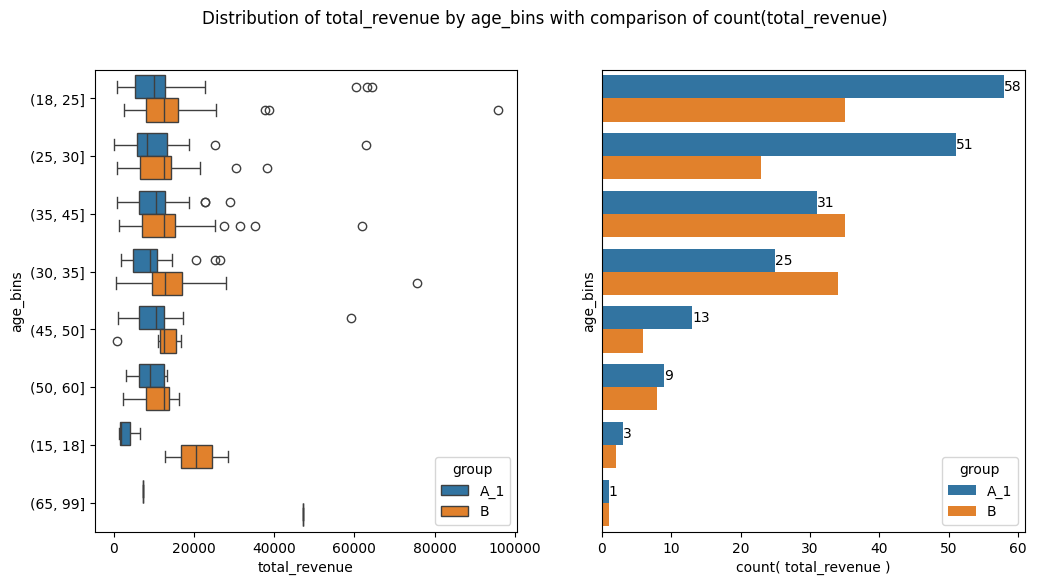

In [210]:
y = 'age_bins' # 'age_bins'
query = "(total_revenue) > 0 & (total_revenue < 100_000) & group.isin(['A_1', 'B'])"
x = 'total_revenue'
sort_values = [y]
hue = 'group'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))

df_order = data.query(query).groupby(y).agg({x:'count'}).reset_index().sort_values(x, ascending = False)
order = {value: index for index, value in enumerate(df_order[y])}
df_plot = data.query(query).groupby([y, hue]).agg({x:'count'}).reset_index().sort_values(x, ascending = False)

sns.boxplot(y = y, 
            x = x, 
            hue = hue, 
            data = data.query(query).sort_values(by=y, key=lambda x: x.map(order)), ax = ax1
           )
sns.barplot(data = df_plot, x = x , y = y, hue = hue, ax = ax2)

ax2.bar_label(ax2.containers[0])
ax2.yaxis.set_major_locator(ticker.NullLocator())
ax2.set_xlabel(f'count( {x} )')
plt.suptitle(f'Distribution of {x} by {y} with comparison of count({x})')
plt.show()

In [212]:
top_feature = df_order[y].iloc[0:5].to_list()
print(f"Рассмотрим только первые 5 {y} в рейтинге по кол-ву пользователей с хотябы одной покупкой: \n{top_feature}")

data_top_country = (data.query(f"{y}.isin({top_feature})")
                        .query("group.isin(['A_1','B'])")
)
data_top_country = data_top_country.assign(
    combination = lambda x: x[hue] + "/" + x[y],
)

print("Рассмотрим взаимодействие факторов")
display(pg.anova(data = data_top_country, dv = x, between = [hue, y]))
print(f"Проведем попарный тест соcтавных категорий {y} и {hue}. Выведем только статистически значемые различия")
display(pg.pairwise_tukey(data = data_top_country, dv = x, between = 'combination').query('`p-tukey` < 0.05'))

Рассмотрим только первые 5 age_bins в рейтинге по кол-ву пользователей с хотябы одной покупкой: 
['(18, 25]', '(25, 30]', '(35, 45]', '(30, 35]', '(45, 50]']
Рассмотрим взаимодействие факторов


,Source,SS,DF,MS,F,p-unc,np2
0,group,1.315956e+07,1.0,1.315956e+07,0.290823,0.589709,0.000037
1,age_bins,1.095772e+08,4.0,2.739430e+07,0.605408,0.658734,0.000310
2,group * age_bins,2.783199e+08,4.0,6.957998e+07,1.537702,0.188281,0.000787
3,Residual,3.535331e+11,7813.0,4.524934e+07,NaN,NaN,NaN


Проведем попарный тест соcтавных категорий age_bins и group. Выведем только статистически значемые различия


C:\WinPython\python-3.11.8.amd64\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\WinPython\python-3.11.8.amd64\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\WinPython\python-3.11.8.amd64\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\WinPython\python-3.11.8.amd64\Lib\site-packages\scipy\integrate\_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges


Итог: Статистически значимого различия во взаимодейтсвии факторов контрольной/тестовой группы и страны не обнаружено